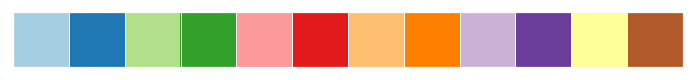

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from scipy.stats import mode
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score
plt.rc('font', size = 11)
sns.set_style('darkgrid')
sns.set_palette(sns.color_palette('Paired'))
sns.palplot(sns.color_palette('Paired'))
sns.set()

In [2]:
dataset_read = pd.read_excel('pilot_experiment_TPM_WTonly.xlsx')
sample_label = dataset_read.columns.values.tolist()

In [3]:
data = pd.read_csv('C:/Users/Tamal/Documents/ThesisFiles/Data Set/Mydata.csv')
data = data.loc[:,(data != 0).any(axis = 0)] #removing all zero value columns from the dataset
unprocessed_dataset = data.loc[:,(data != 0).any(axis = 0)]

The raw dataset contains 30 samples as rows and 29458 features as columns. after removing the Zero value columns, 25438 features were found. The zero columns were removed because they are not useful for the exploratory analysis.
from this features it is possible to represent the data differently by (25438 * 25437)/2 times.

By visualizing the coordinates it can be easily said that there is no linear relationship between the dimensions.

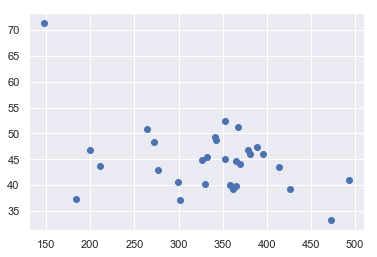

In [4]:
plt.scatter(data['gene_1'], data['gene_29451'])

### Correlation measure
Correlation is a measure of relationship between variables that is measured on a -1 to 1 scale. The closer the correlation value is to -1 or 1 the stronger the relationship, the closer to 0, the weaker the relationship. It measures how change in one variable is associated with change in another variable.

### Pearson correlation assumptions
In order for the results of a Pearson correlation test to be valid, the data must meet these assumptions:
- The sample is independently and randomly drawn.
- A linear relationship between the two variables is present.
- When plotted, the lines form a line and is not curved.

In [5]:
from scipy import stats
stats.pearsonr(data['gene_1'], data['gene_6'])
#The output is not labelled, but it is returned in the order of (r-value, p-value)

(-0.34059565922296764, 0.06551097529476643)

In [6]:
y = sorted(list(range(10)) *3)
sample_list = sorted(['L1T1', 'L1T2','L1T3', 'L1T4', 'L3T2', 'L3T3', 'L3T4', 'L5T3', 'L5T4', 'L7T4'] * 3)
sample_arr = np.array(sample_list)

In [7]:
unprocessed_dataset['y'] = y
dataset = unprocessed_dataset
X = dataset.iloc[:, :-1].values 
y_true = dataset.iloc[:, -1].values

Working with high dimen

In [8]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc_X = sc.fit_transform(X)

29 components retain 99.99% variance of the data and shape (30, 29).


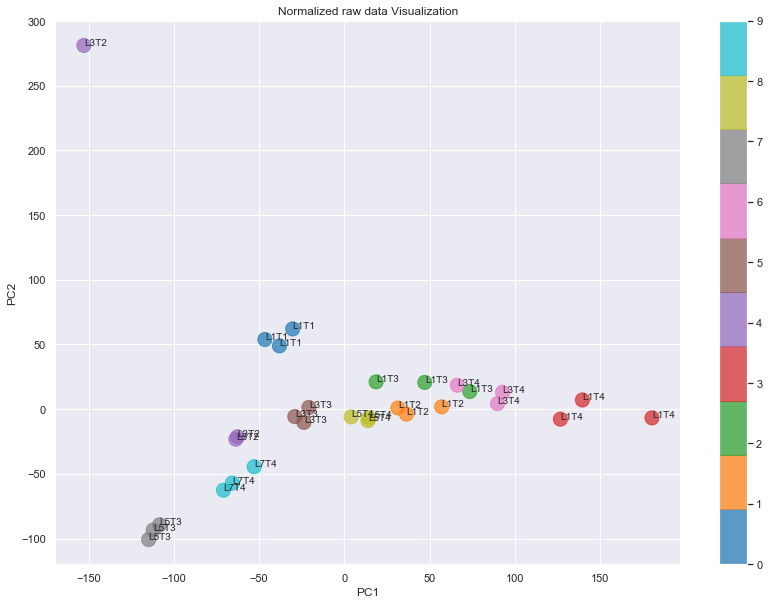

In [9]:
pca = PCA(.9999) #retaining 99.99 variaance of the data
X_trans = pca.fit_transform(sc_X)
num_components = pca.n_components_
print('{} components retain 99.99% variance of the data and shape {}.'.format(num_components, X_trans.shape))

fig, ax = plt.subplots(figsize = (14,10))
plt.scatter(X_trans[:,0], X_trans[:,1], c = y, s = 200, cmap = 'tab10', alpha = 0.7)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar()
plt.title('Normalized raw data Visualization')
for i, txt in enumerate(sample_list):
    ax.annotate(txt, (X_trans[:,0][i], X_trans[:,1][i]))
#plt.savefig('C:/Users/Tamal/Documents/Thesis Files/Images/Report/rawData_Normalized.png', dpi = 200)
plt.show()

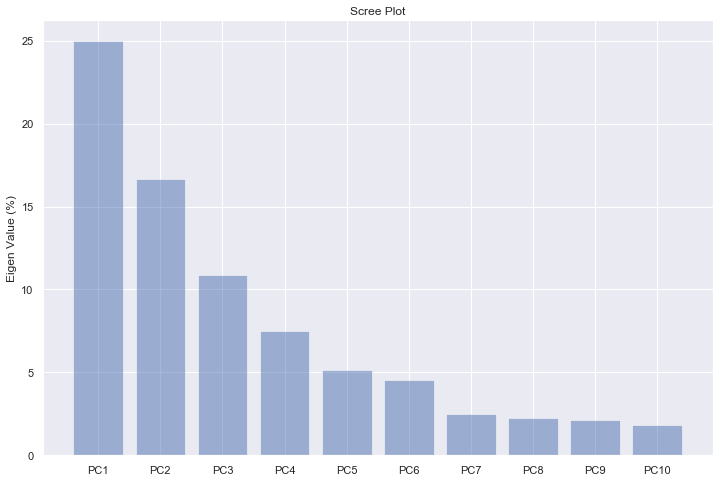

In [10]:
pcs = ('PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10')
y_pos = np.arange(len(pcs))
eigen_val = pca.explained_variance_ratio_[:10] * 100

plt.figure(figsize = (12,8))
plt.bar(y_pos, eigen_val, align='center', alpha=0.5, label = eigen_val)
plt.xticks(y_pos, pcs)
plt.ylabel('Eigen Value (%)')
plt.title('Scree Plot') 
plt.show()

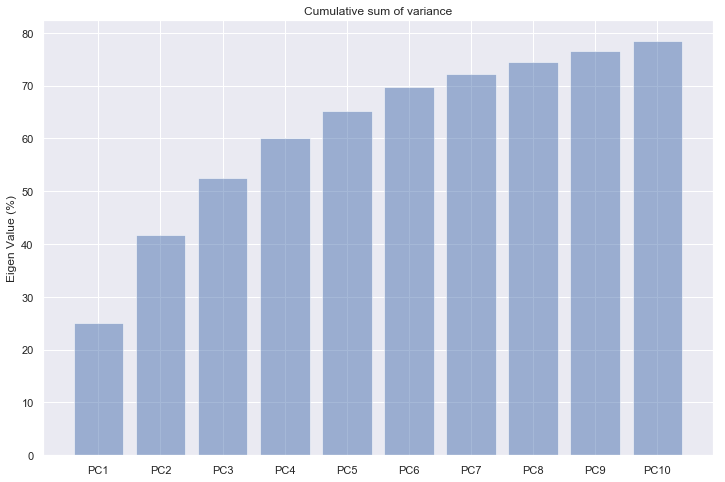

In [12]:
pcs = ('PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10')
y_pos = np.arange(len(pcs))
eigen_val = np.cumsum(pca.explained_variance_ratio_[:10]) * 100

plt.figure(figsize = (12,8))
plt.bar(y_pos, eigen_val, align='center', alpha=0.5, label = eigen_val)
plt.xticks(y_pos, pcs)
plt.ylabel('Eigen Value (%)')
plt.title('Cumulative sum of variance') 
plt.show()

In [13]:
pcs_list = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']
loadings = pd.DataFrame(pca.components_[:10,:],columns = data.columns, index = pcs_list)

def variable_contrib(index_n):
    pc_loadings = loadings.loc[loadings.index[index_n]]
    pc_loadings = pc_loadings.to_frame()
    sorted_loadings = pc_loadings.sort_values(pcs_list[index_n]).abs()
    gene_contrib = sorted_loadings.loc[(sorted_loadings[pcs_list[index_n]] >= 0.01)].T
    genes = gene_contrib.columns.values.tolist()
    
    return gene_contrib, genes

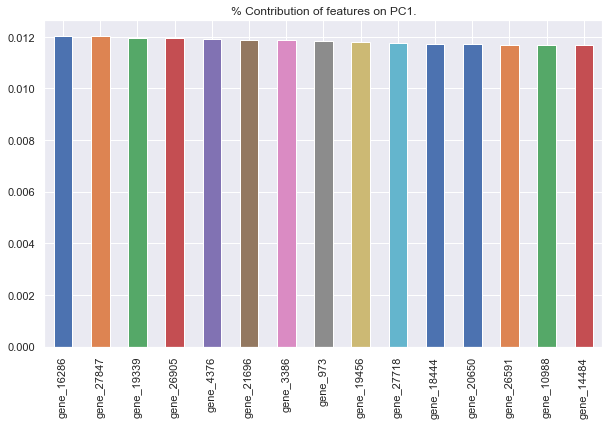

In [14]:
gene_contrib, genes = variable_contrib(0)
gene_contrib.iloc[0, 0:15].plot(kind = 'bar', figsize = (10,6), title = '% Contribution of features on {}.'.format(list(gene_contrib.index)[0]))


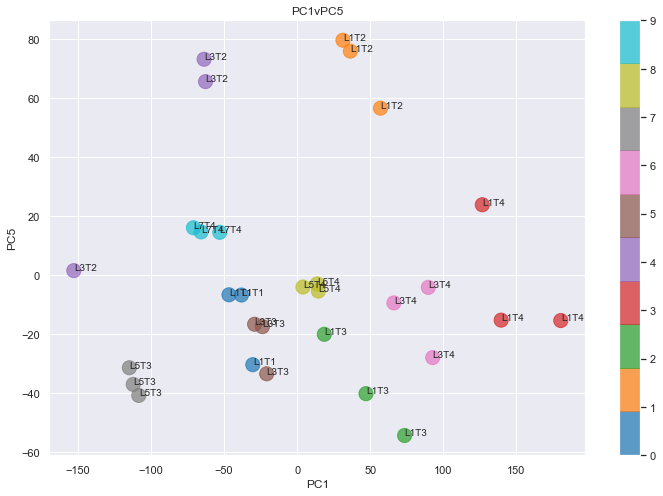

In [15]:
pcs_list = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']

def pcs_visualization(pc1_ind, pc2_ind):
    fig, ax = plt.subplots(figsize = (12,8))
    plt.scatter(X_trans[:,pc1_ind], X_trans[:,pc2_ind], c = y, s = 200, cmap = 'tab10', alpha = 0.7)
    plt.xlabel(pcs_list[pc1_ind])
    plt.ylabel(pcs_list[pc2_ind])
    plt.title(pcs_list[pc1_ind] + 'v' + pcs_list[pc2_ind])
    plt.colorbar()
    for i, txt in enumerate(sample_list):
        ax.annotate(txt, (X_trans[:,pc1_ind][i], X_trans[:,pc2_ind][i]))
    return plt.show()

pcs_visualization(0,4)

In [78]:
def data_transformation(input_data):
    #data normalization or standardization
    sc = StandardScaler()
    normalized_data = sc.fit_transform(input_data)
    
    #Linear dimensionality reduction using PCA
    pca = PCA(0.9999)
    pca_transformed = pca.fit_transform(normalized_data)
    
    #Non-linear dimensionality reduction using KPCA
    kpca = KernelPCA(n_components = 5, kernel = 'rbf')
    kpca_transformed = kpca.fit_transform(normalized_data)
    
    #Non-linear dimensionality reduction using TSNE
    tsne = TSNE(n_components = 2, n_iter = 200000, perplexity = 9, init = 'pca')
    tsne_transformed = tsne.fit_transform(normalized_data)
    
    return normalized_data, pca_transformed, kpca_transformed, tsne_transformed


In [79]:
def k_means(m_data):
    kmeans = KMeans(n_clusters = 10, init = 'k-means++', max_iter = 300, n_init = 100)
    y_km = kmeans.fit_predict(m_data)
    
    return y_km

In [80]:
def cluster_visualization(input_data):
    plt.rc('font', size = 10)
    fig, ax = plt.subplots(figsize = (14,10))
    plt.scatter(input_data[:,0], input_data[:,1], c = y_result, s = 200, cmap = plt.get_cmap('tab10', 10), alpha = 0.8)
    for i, txt in enumerate(sample_list):
        ax.annotate(txt, (input_data[:,0][i], input_data[:,1][i]))
    plt.colorbar(ticks = range(10), label = 'clusters')
    plt.title('KMeans')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    
    return plt.show()

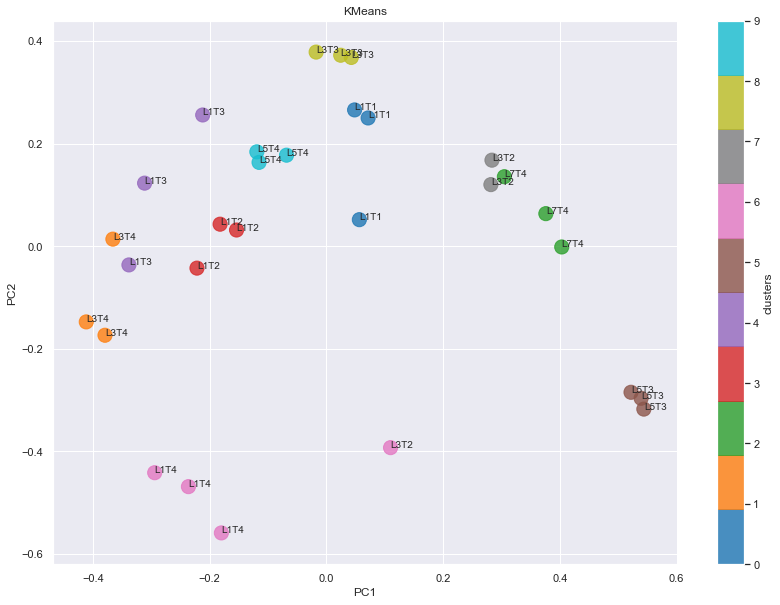

In [81]:
normalized_data, pca_trans, kpca_trans, tsne_trans = data_transformation(X)
y_result = k_means(kpca_trans)
cluster_visualization(kpca_trans)

In [46]:
adjusted_rand_score = metrics.adjusted_rand_score(y_true, y_result)
print('Adjusted rand score for KMeans using KernelPCA {}.'.format(adjusted_rand_score))

homogeneity_score, completeness_score, V_score = metrics.homogeneity_completeness_v_measure(y_true, y_result)
print('Homogeneity score for KMeans using KernelPCA {}.'.format(homogeneity_score))
print('Completeness info score for KMeans using KernelPCA {}.'.format(completeness_score))

Adjusted rand score for KMeans using KernelPCA 0.9118541033434651.
Homogeneity score for KMeans using KernelPCA 0.9674374599615713.
Completeness info score for KMeans using KernelPCA 0.9722198882874836.


In [43]:
import random

#choosing from which class the variables will be drawn
class_1 = X[[9,10,11], :]
class_2 = X[[15,16,17], :]

test_sample = np.zeros(class_1.shape[1])

for i in range(class_1.shape[1]):
    rand = random.random()
    
    if rand <= 0.40:
        test_sample[i] = random.uniform(np.amin(class_2[:,i]), np.amax(class_2[:,i]))
    else:
        test_sample[i] = random.uniform(np.amin(class_1[:,i]), np.amax(class_1[:,i]))
        
test_sample = test_sample.reshape(1, -1) #reshaping 

In [ ]:
test_sample_label = ['test_Sample_1']
sc_ = StandardScaler()
sc_X = sc_.fit_transform(X)
#put new sample or sample list here
test_sample_ = sc_.transform(test_sample)

kpca_ = KernelPCA(n_components = 5, kernel = 'rbf')
X_transform_ = kpca_.fit_transform(sc_X)
test_sample_trans_ = kpca_.transform(test_sample_)

tsne = TSNE(n_components = 2, n_iter = 200000, perplexity = 3, init = 'pca')
tsne_transformed = tsne.fit_transform(sc_X)
test_sample_tsne_tr = tsne.transform(test_sample_)

km_kpca_ = KMeans(n_clusters = 10, init = 'k-means++', max_iter = 300, n_init = 100)
y_train_ = km_kpca_.fit_predict(X_transform_)
y_test_ = km_kpca_.predict(test_sample_trans_)

plt.rc('font', size = 10) #setting the front size in the plot
fig, ax = plt.subplots(figsize = (14,10))
plt.scatter(X_transform_[:,0], X_transform_[:,1], c = y_train_, s = 200, cmap = plt.get_cmap('tab10', 10), alpha = 0.7)
plt.scatter(test_sample_trans_[:,0], test_sample_trans_[:,1], c = y_test_, s = 200, cmap = plt.get_cmap('tab10', 10), alpha = 0.7)

for i, txt in enumerate(sample_list):
    ax.annotate(txt, (X_transform_[:,0][i], X_transform_[:,1][i]))
    
for j, txt in enumerate(test_sample_label):
    ax.annotate(txt, (test_sample_trans_[:,0][j], test_sample_trans_[:,1][j]))
    
plt.xlabel('KPCA C1')
plt.ylabel('KPCA C2')
plt.colorbar(ticks = range(10), label = 'Clusters')
plt.clim(0,10)
plt.title('KMeans with reduced dimension of normalized data by KPCA')
plt.show()

In [ ]:
def data_evaluation(input_data, test_data):
    #data normalization or standardization
    sc = StandardScaler()
    normalized_data = sc.fit_transform(input_data)
    normalized_test = sc.transform(test_data)
    
    #Linear dimensionality reduction using PCA
    pca = PCA(0.9999)
    pca_transformed = pca.fit_transform(normalized_data)
    pca_test = pca.transform(normalized_test)
    
    #Non-linear dimensionality reduction using KPCA
    kpca = KernelPCA(n_components = 5, kernel = 'rbf')
    kpca_transformed = kpca.fit_transform(normalized_data)
    kpca_test = kpca.transform(normalized_test)
    
    #Non-linear dimensionality reduction using TSNE
    tsne = TSNE(n_components = 2, n_iter = 200000, perplexity = 3, init = 'pca')
    tsne_transformed = tsne.fit_transform(normalized_data)
    tsne_test = tsne.transform(normalized_test)
    
    return normalized_data, pca_transformed, kpca_transformed, tsne_transformed